# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

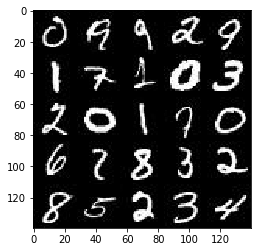

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

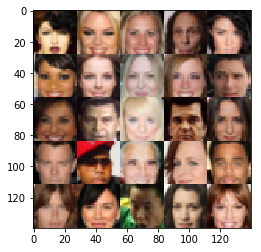

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1 # Leaky relu alpha
        
        # Input layer is 28x28x3
        resized_images=tf.image.resize_images(images, [32, 32])
        
        x1 = tf.layers.conv2d(resized_images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.2)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.1 # Leaky relu
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        result_img = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        result_img = tf.layers.dropout(result_img, rate=0.3)
        # 32x32x3
        
        logits=tf.image.resize_images(result_img, [28, 28])
        
        out = tf.tanh(logits) * 0.5
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    #tf.reset_default_graph()
    out_channel_dim = data_shape[-1]

    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 50 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3955... Generator Loss: 4.3744
Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 13.6388
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 9.9254
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.3878
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.6512


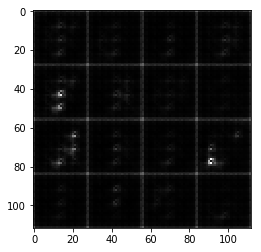

Epoch 1/2... Discriminator Loss: 0.8836... Generator Loss: 1.3969
Epoch 1/2... Discriminator Loss: 2.0947... Generator Loss: 0.2710
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.7492
Epoch 1/2... Discriminator Loss: 1.8101... Generator Loss: 0.3608
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.9073


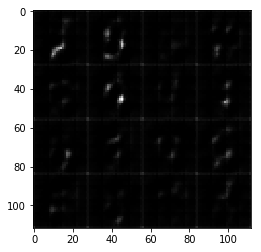

Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.2122
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 0.9269


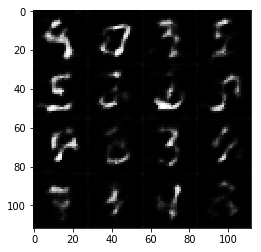

Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 1.3935
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 0.9738
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 1.7801


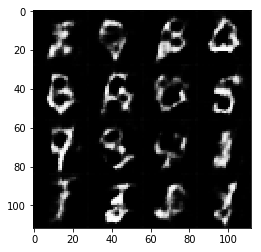

Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 1.4137
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 1.8349


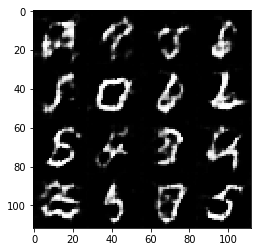

Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 1.0163


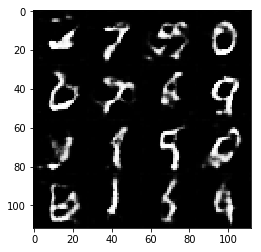

Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.4537
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 1.4458
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 1.0213


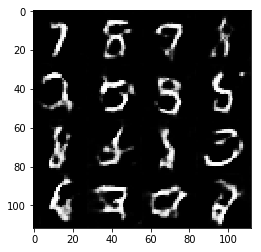

Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 1.5607
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 1.0589
Epoch 1/2... Discriminator Loss: 1.5663... Generator Loss: 0.4150


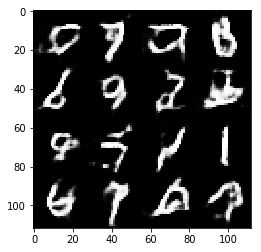

Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.7001
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 1.4429... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.8005


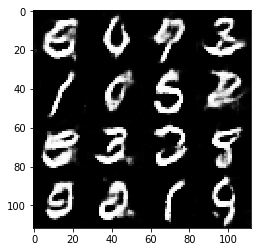

Epoch 1/2... Discriminator Loss: 1.5764... Generator Loss: 2.0626
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 1.9063
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.6831


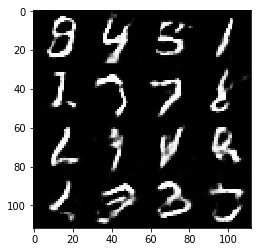

Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 1.6952
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.8796
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.1166


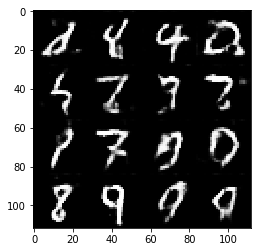

Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 2.3582
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 1.4914
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.7540


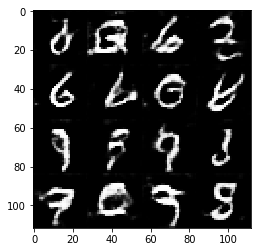

Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 2.0310
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 1.7290


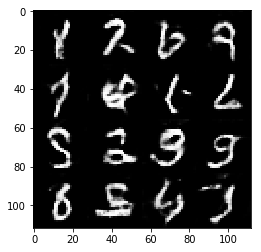

Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 1.9547
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.4939... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 1.7223


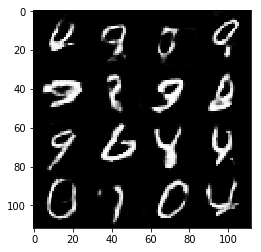

Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 1.4977


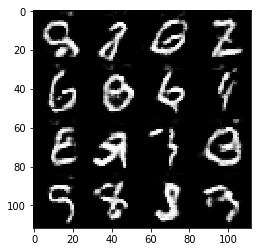

Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 1.8834
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.3353
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.1245
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.3617


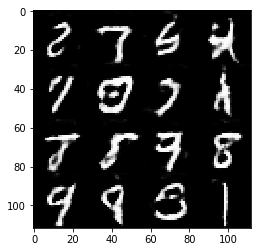

Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 1.5692
Epoch 1/2... Discriminator Loss: 1.5490... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.5421... Generator Loss: 2.4561
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.7263


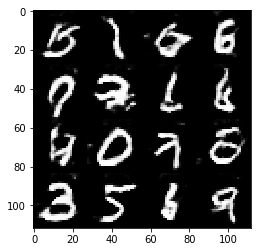

Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 1.6459
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.8642
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.9322


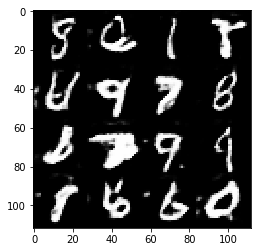

Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 2.5419... Generator Loss: 0.1764
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.1368
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.6083


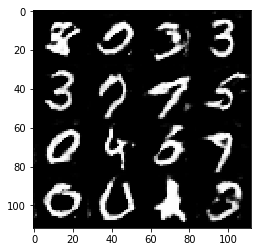

Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 2.4122
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 1.8250
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.6282
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 1.6028


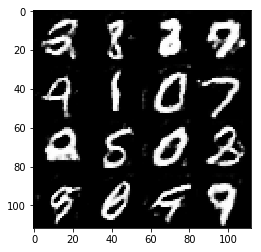

Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 1.4128
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.3657
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 1.4911... Generator Loss: 0.5089


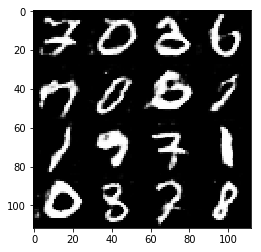

Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.1559
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.6612
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 2.2745
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 1.2512
Epoch 2/2... Discriminator Loss: 1.6904... Generator Loss: 2.9686


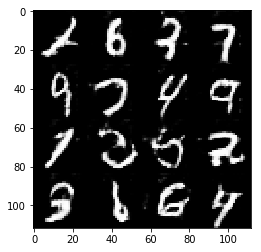

Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 2.2106
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 1.1033
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.6269


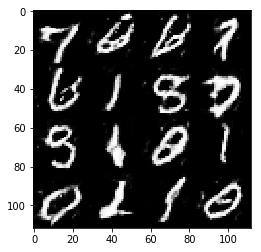

Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.5420... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 0.8971... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 1.1057


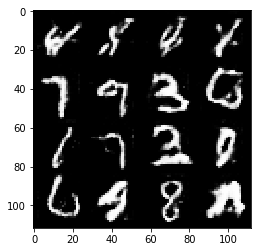

Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 0.9479... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.4423
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 2.4668
Epoch 2/2... Discriminator Loss: 2.0213... Generator Loss: 0.2680


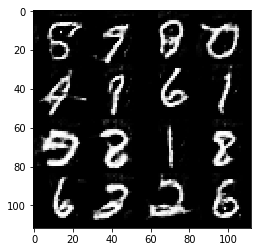

Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 0.9547
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.9246
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 2.3313


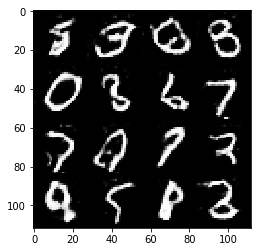

Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.0923
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.6095
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.8881
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.7921


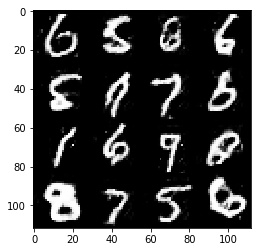

Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 1.9085
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.2328
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.9720
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 2.3821... Generator Loss: 0.1983


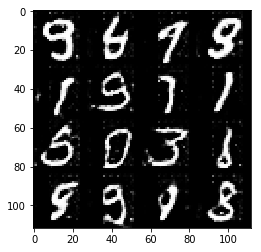

Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 1.9100
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.0730
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.7794
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.5835


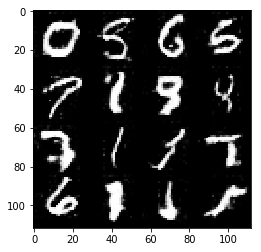

Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 1.1758
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.1720


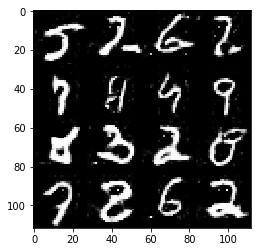

Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 1.0833
Epoch 2/2... Discriminator Loss: 0.8626... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 1.6929
Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 2.0639


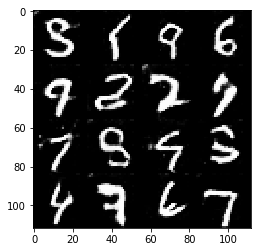

Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.1769
Epoch 2/2... Discriminator Loss: 1.5262... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 1.0492... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 0.9718... Generator Loss: 0.9433
Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 1.0239


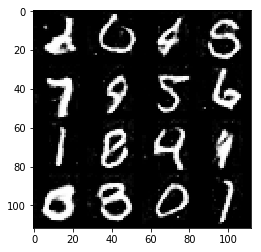

Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 3.5694... Generator Loss: 4.3201
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 1.4727


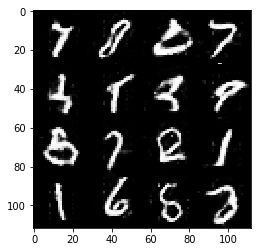

Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.5259
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.6136


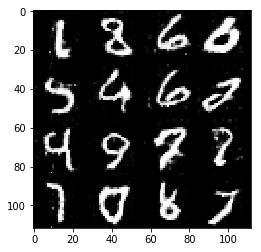

Epoch 2/2... Discriminator Loss: 1.6758... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.8710
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 2.1243
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.0385
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.8409


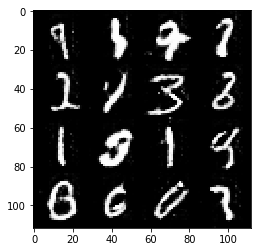

Epoch 2/2... Discriminator Loss: 1.5191... Generator Loss: 0.4939
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 0.7387... Generator Loss: 1.5146
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.8353


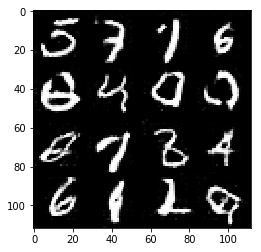

Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.5731
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 1.0555
Epoch 2/2... Discriminator Loss: 1.8578... Generator Loss: 3.3038
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.6457


In [12]:
batch_size = 65
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 12.8534
Epoch 1/1... Discriminator Loss: 2.4510... Generator Loss: 4.9691
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 1.2651


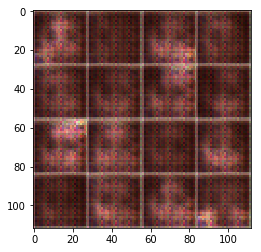

Epoch 1/1... Discriminator Loss: 1.9179... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 1.0051


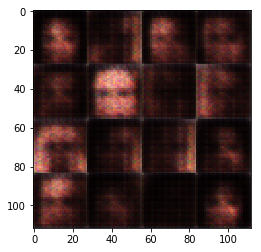

Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.7751
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.4565


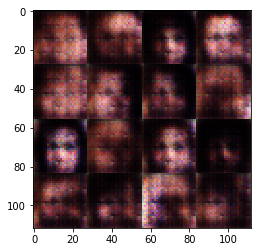

Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 1.1154


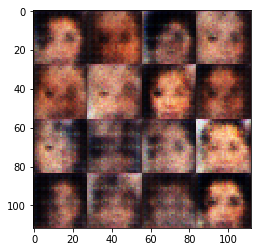

Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 1.0238


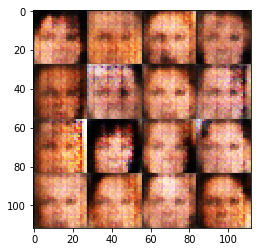

Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.2295


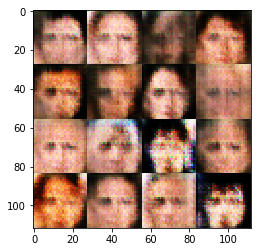

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7216


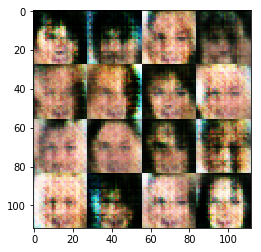

Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 1.6045
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 1.4323
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 1.1921


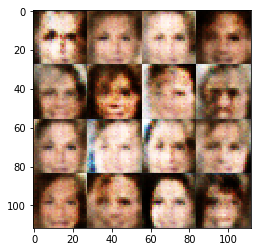

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.7464


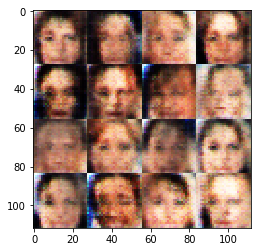

Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.2904


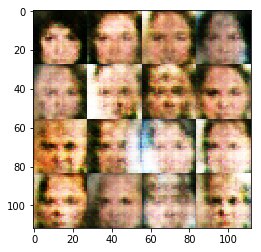

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.5404


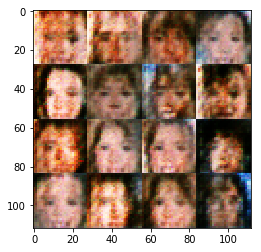

Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.8418


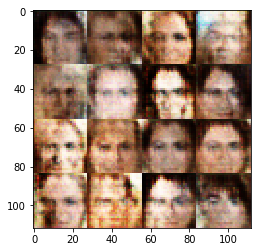

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.7157


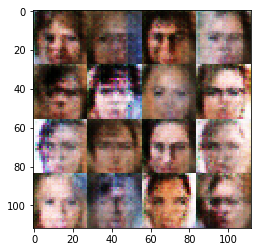

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.2542


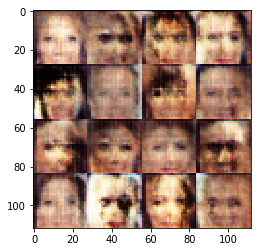

Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.9786


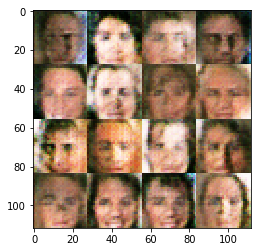

Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7319


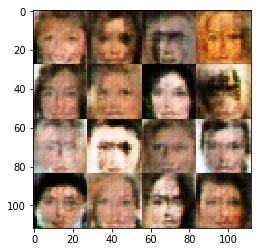

Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7360


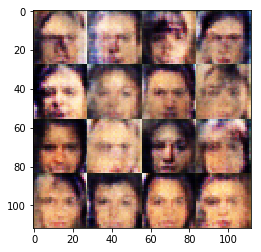

Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7574


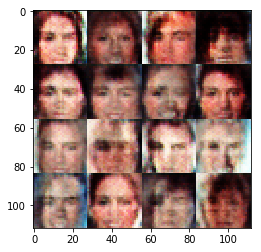

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8215


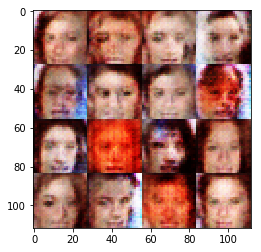

Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.0680


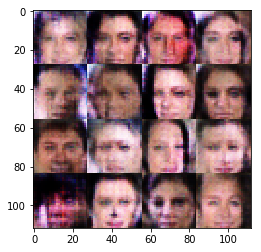

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7370


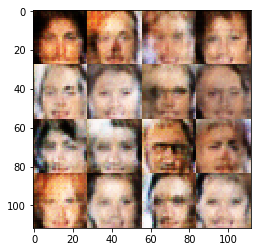

Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 1.0196
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7109


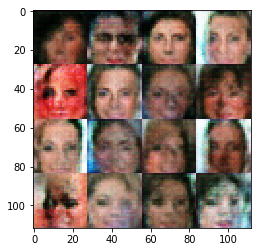

Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 1.5093
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 1.1323


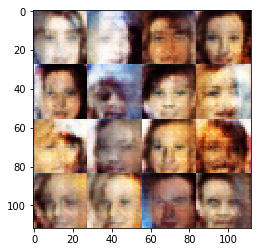

Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.2488


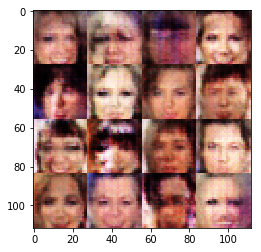

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.8468


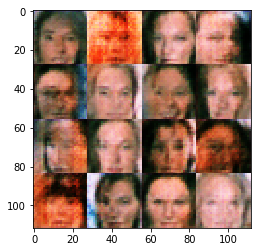

Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.8838


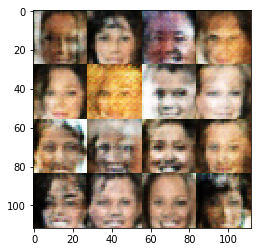

Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6516


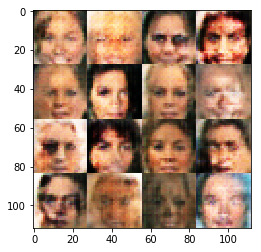

Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.8847


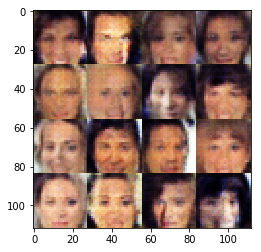

Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8206


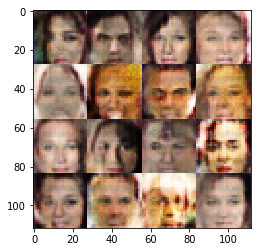

Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.0556


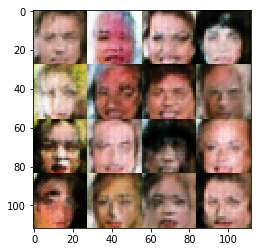

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.9008


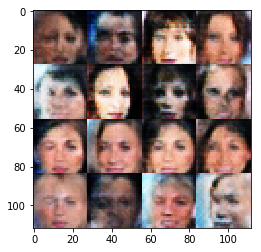

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7316


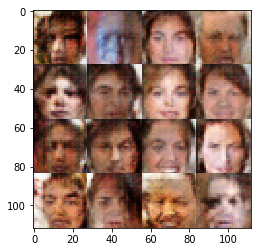

Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7497


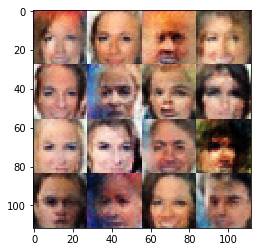

Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.5311


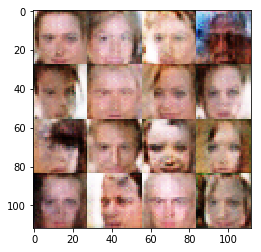

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.4363


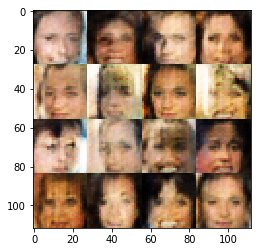

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 1.4028


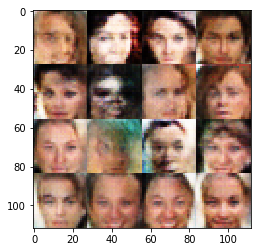

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.0519


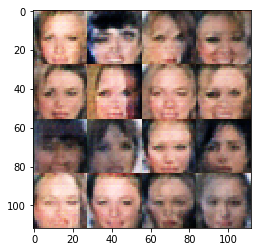

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.6922


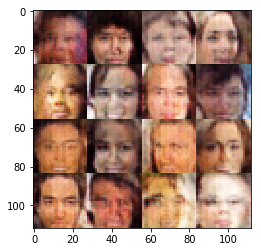

Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7577


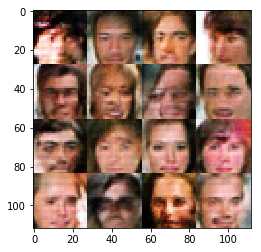

Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.9098


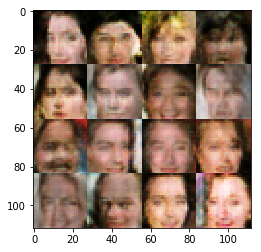

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.6898


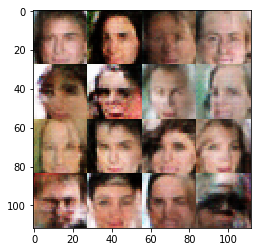

Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7234


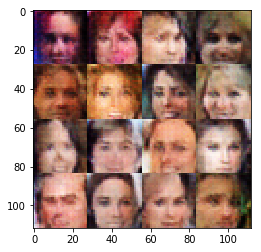

Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6530


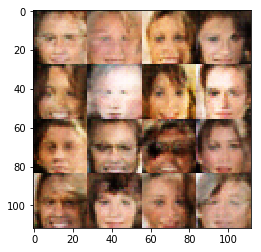

Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8902


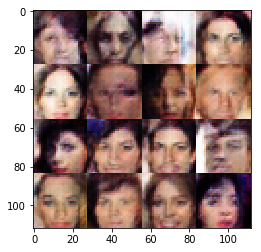

Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6273


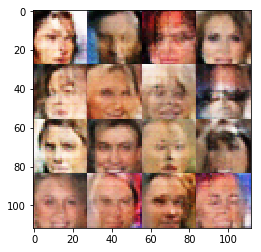

Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7644


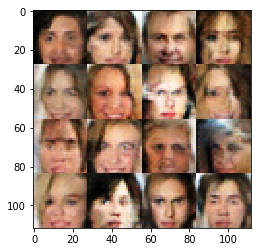

Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6981


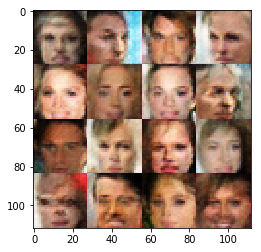

Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.9782


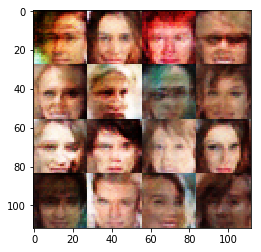

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7889


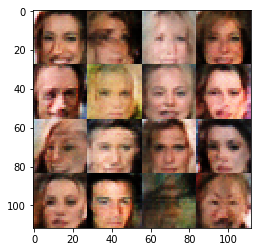

Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.9106


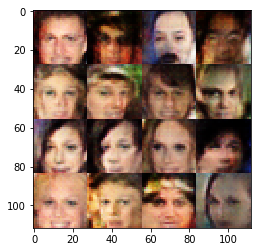

Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.6736


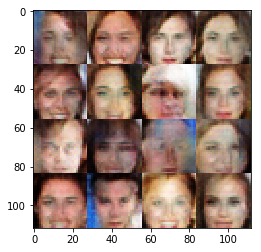

Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6898


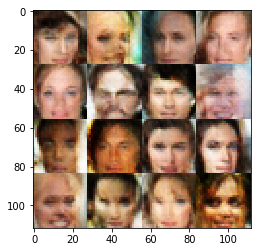

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.6056


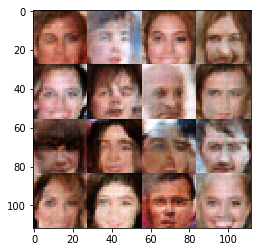

Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7189


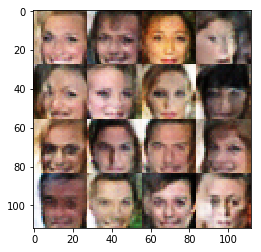

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.0068


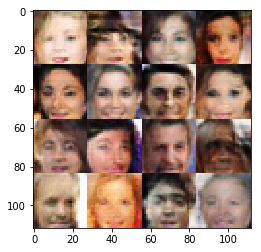

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.9499


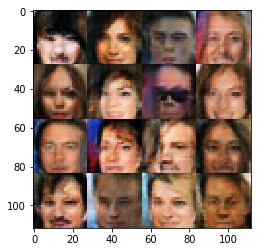

Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.1886


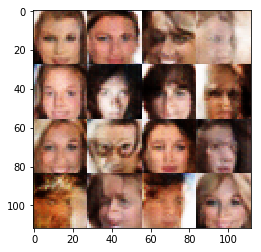

Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.6088... Generator Loss: 0.4005


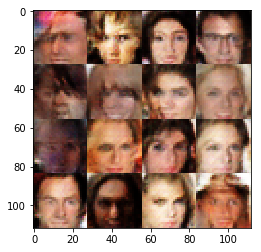

Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7656


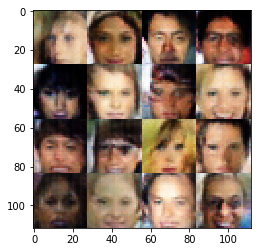

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5991


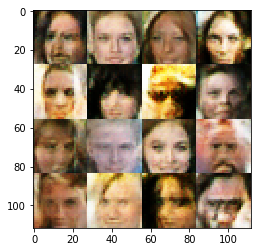

Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.8560


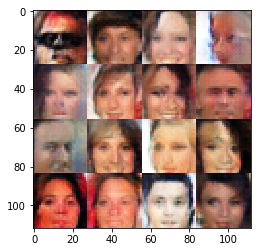

Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8701


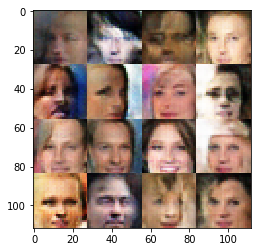

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7386


In [13]:
batch_size = 65
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.